# Estimators

We provide here an example of scikit-dimension estimators performances on two different proteins, [villin](#villin) and [NTL9](#ntl9).

The test is performed on dihedral angles and data is divided between folded and unfolded trajectories.

## Villin

In [1]:
from md_intrinsic_dimension import intrinsic_dimension, section_id, secondary_structure_id
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
import matplotlib as mpl
import seaborn as sns
import logging
from moleculekit.molecule import Molecule
from itertools import product

#build personalised cmap
colors = mpl.colors.ListedColormap(
    name="discrete-bicolor",
    colors=["#e9ff99","#ceff29", "#A5CC21", "#C099F3", "#6100e0", "#4E00B3"])

cmap = plt.get_cmap('jet') 
#set font dimension
plt.rcParams.update({
	'axes.titlesize': 13,
	'axes.labelsize': 13,
	'xtick.labelsize': 11,
	'ytick.labelsize': 11,
	'legend.fontsize': 11,
	'legend.title_fontsize': 13,
	'lines.linewidth' : 1,
	'lines.markersize': 8,
})

In [ ]:
data = []
states = ['u0','u1', 'u2', 'f0', 'f1', 'f2'] 
#estimators = ['CorrInt','lPCA', 'MADA', 'MiND_ML','MLE', 'MOM', 'TLE', 'TwoNN']
#estimators = ['MiND_ML']
estimators = ['CorrInt', 'DANCo', 'ESS', 'FisherS','KNN', 'lPCA', 'MADA', 'MiND_ML', 'MLE', 'MOM', 'TLE', 'TwoNN']
projection_method = 'Dihedrals'  # or 'Distances'
projection_kwargs = {'skip': 3}

for estimator, state in product(estimators, states):
    if estimator == 'MiND_ML':
         mean_all, mean_last= intrinsic_dimension(topology='examples/villin/2f4k.pdb', trajectory=f'examples/villin/2f4k_{state}.xtc', projection_method=projection_method, projection_kwargs = projection_kwargs,id_method='global',id_kwargs={'estimator': estimator, 'D': 100}, verbose=True)
    else:    
         mean_all, mean_last= intrinsic_dimension(topology='examples/villin/2f4k.pdb', trajectory=f'examples/villin/2f4k_{state}.xtc', projection_method=projection_method, projection_kwargs = projection_kwargs,id_method='global',id_kwargs={'estimator': estimator}, verbose=True)

    data.append({'trajectory': state,
	  'estimator': estimator,
	  'mean_all': mean_all,
	  'mean_last': mean_last,
      })
data = pd.DataFrame(data)
data["folded"] = data["trajectory"].str.startswith("f")

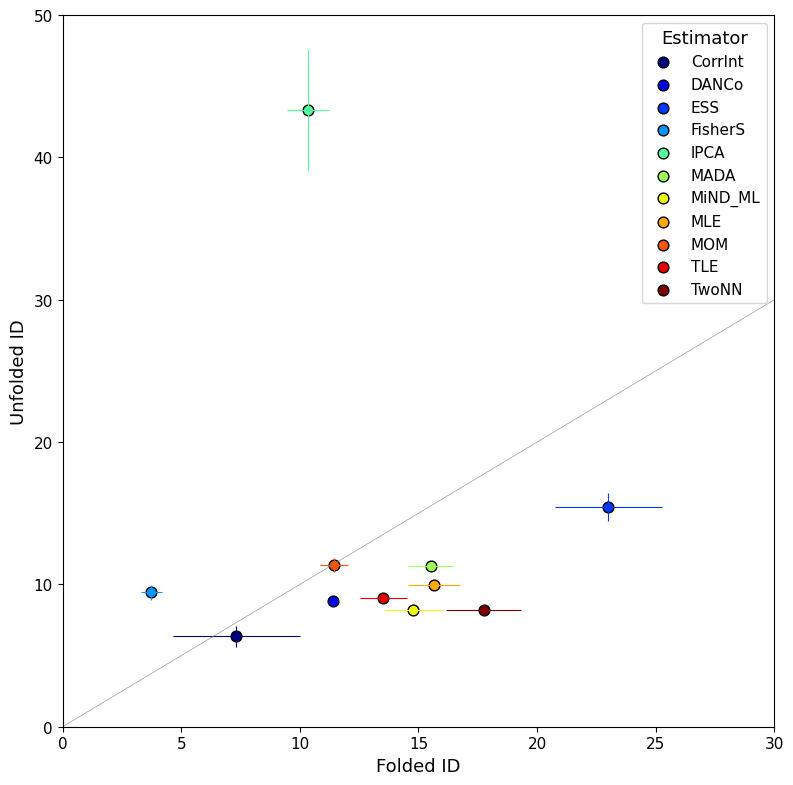

In [3]:
fig, ax =plt.subplots(figsize=(8,8))
ax = plt.gca()
group=data.groupby('trajectory')
estimators = data['estimator'].unique()

for i, estimator in enumerate(estimators):
    if estimator == "KNN": 
        continue

    color = cmap(i / (len(estimators) - 1)) 
    estimator_data = data[data['estimator'] == estimator]
    folded_values = estimator_data[estimator_data['folded']]['mean_all'].dropna()
    unfolded_values = estimator_data[~estimator_data['folded']]['mean_all'].dropna()
    x_mean = folded_values.mean()
    y_mean = unfolded_values.mean()
    x_std = folded_values.std(ddof=1) / np.sqrt(len(folded_values))
    y_std = unfolded_values.std(ddof=1) / np.sqrt(len(unfolded_values))

    ax.errorbar(x_mean, y_mean, xerr=x_std, yerr=y_std, fmt='none', ecolor=color, elinewidth=0.8,)
    ax.scatter(x_mean, y_mean,facecolors=color, edgecolors='black',s=60, label=estimator)

    #rect = patches.Rectangle((x_mean - x_std, y_mean - y_std), 2 * x_std, 2 * y_std)
    #pc = PatchCollection([rect],  facecolor=color,alpha=0.45,edgecolor=cmap(i),linewidth=0.5,linestyle="-")
    #ax.add_collection(pc)

ax.set_box_aspect(1)    
min_val = data['mean_all'].min() - 0.5
max_val = data['mean_all'].max() + 0.5
#plt.axline((10, 10), (30, 30), lw=0.5, color='black', alpha=0.8)
plt.axline((5, 5), (12, 12), lw=0.5, color='grey', alpha=0.8)
plt.xlabel('Folded ID')
plt.ylabel('Unfolded ID')
plt.legend( loc='upper right', title= 'Estimator')

# Set equal axis limits for better visualization
plt.ylim(0, 50)
plt.xlim(0, 30)

plt.tight_layout()
#plt.savefig('../extra/villin_foldedvsunfolded_std_dihedrals.pdf', dpi=300, bbox_inches='tight')
plt.show()


Because of the huge gap between folded replicas, in the previous plot we omitted KNN, which is shown below instead.

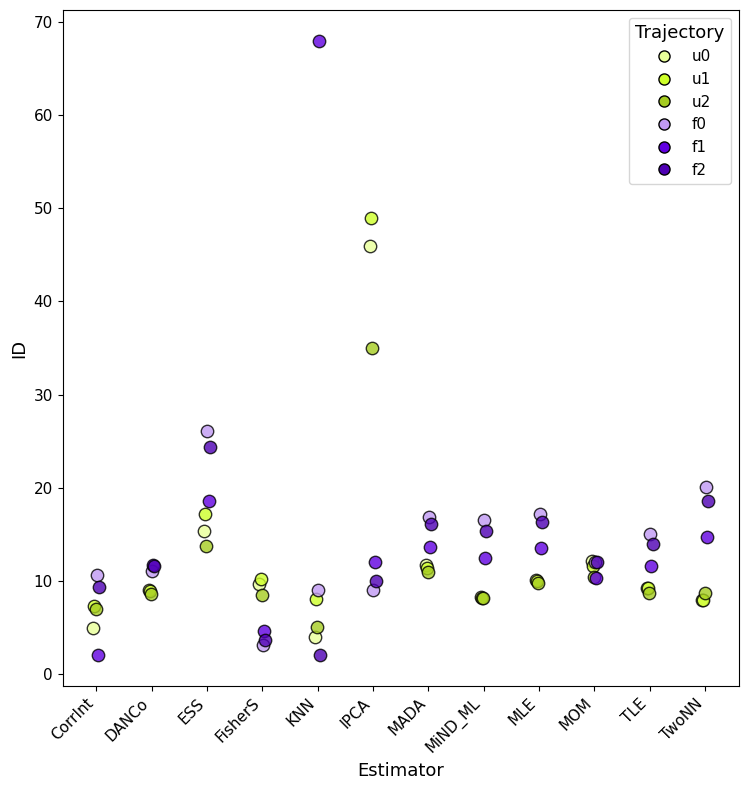

In [4]:

estimators = data["estimator"].unique()
states = data["trajectory"].unique()

fig, ax = plt.subplots(figsize=(8,8))

# assign colors from your custom cmap
color_map = {state: colors(i % colors.N) for i, state in enumerate(states)}

shift_amount = 0.05
n_traj = len(states)
shifts = np.linspace(-shift_amount, shift_amount, n_traj)
shift_map = dict(zip(states, shifts))

for _, row in data.iterrows():
    est_idx = np.where(estimators == row["estimator"])[0][0]

    # assign a slight offset depending on trajectory
    x = est_idx + shift_map[row["trajectory"]]

    mean_val = row["mean_all"]
    this_color = color_map[row["trajectory"]]

    ax.scatter(
        x, mean_val,
        color=this_color,
        edgecolor="black",
        alpha=0.8,
        s=80,
    )
ax.set_box_aspect(1)

# ticks & labels
ax.set_xticks(range(len(estimators)))
ax.set_xticklabels(estimators, rotation=45, ha="right")
ax.set_ylabel("ID")
ax.set_xlabel("Estimator")

# legend handles (consistent with scatter colors)
handles = [
    plt.Line2D([0],[0], marker='o', color='w',
               markerfacecolor=color_map[s], markeredgecolor='black',
               markersize=8, label=s)
    for s in states
]
ax.legend(handles=handles, title='Trajectory', loc='best')

plt.tight_layout()
#plt.savefig('../extra/villin_estimators_std.pdf', dpi=300)
plt.show()


## NTL9

In [ ]:
data2 = []
states = ['u0','u1', 'u2', 'f0', 'f1', 'f2'] 
#estimators = ['CorrInt','lPCA', 'MADA', 'MiND_ML','MLE', 'MOM', 'TLE', 'TwoNN']
#estimators = ['MiND_ML']
estimators = ['CorrInt', 'DANCo', 'ESS', 'FisherS','KNN', 'lPCA', 'MADA', 'MiND_ML', 'MLE', 'MOM', 'TLE', 'TwoNN']
projection_method = 'Dihedrals'  # or 'Distances'
projection_kwargs = {'skip': 3}


for estimator, state in product(estimators, states):
    if estimator == 'MiND_ML':
         mean_all, mean_last = intrinsic_dimension(topology='examples/NTL9/ntl9.pdb', trajectory=f'examples/NTL9/ntl9_{state}.xtc', projection_method=projection_method, projection_kwargs = projection_kwargs,id_method='global',id_kwargs={'estimator': estimator, 'D': 100}, verbose=True)
    else:    
         mean_all, mean_last = intrinsic_dimension(topology='examples/NTL9/ntl9.pdb', trajectory=f'examples/NTL9/ntl9_{state}.xtc', projection_method=projection_method, projection_kwargs = projection_kwargs,id_method='global',id_kwargs={'estimator': estimator}, verbose=True)

    data2.append({'trajectory': state,
	  'estimator': estimator,
	  'mean_all': mean_all,
	  'mean_last': mean_last,
     })
data2 = pd.DataFrame(data2)
data2["folded"] = data2["trajectory"].str.startswith("f")


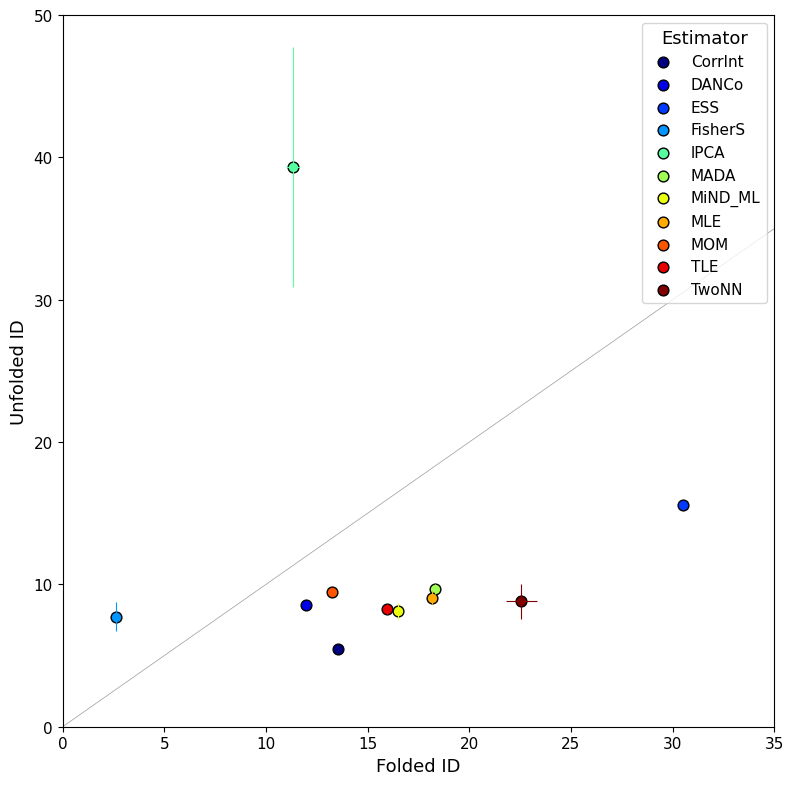

In [6]:

fig, ax = plt.subplots(figsize=(8,8))
ax = plt.gca()
group=data2.groupby('trajectory')
estimators = data2['estimator'].unique()

for i, estimator in enumerate(estimators):
    if estimator == "KNN": 
        continue

    color = cmap(i / (len(estimators) - 1)) 
    estimator_data2 = data2[data2['estimator'] == estimator]
    folded_values = estimator_data2[estimator_data2['folded']]['mean_all'].dropna()
    unfolded_values = estimator_data2[~estimator_data2['folded']]['mean_all'].dropna()
    x_mean = folded_values.mean()
    y_mean = unfolded_values.mean()
    x_std = folded_values.std(ddof=1) / np.sqrt(len(folded_values))
    y_std = unfolded_values.std(ddof=1) / np.sqrt(len(unfolded_values))

    ax.errorbar(x_mean, y_mean, xerr=x_std, yerr=y_std, fmt='none', ecolor=color, elinewidth=0.8,)
    ax.scatter(x_mean, y_mean,facecolors=color, edgecolors='black',s=60, label=estimator)

    #rect = patches.Rectangle((x_mean - x_std, y_mean - y_std), 2 * x_std, 2 * y_std)
    #pc = PatchCollection([rect],  facecolor=color,alpha=0.45,edgecolor=cmap(i),linewidth=0.5,linestyle="-")
    #ax.add_collection(pc)
min_val = data2['mean_all'].min() - 0.5
max_val = data2['mean_all'].max() + 0.5
ax.set_box_aspect(1)
#plt.axline((10, 10), (30, 30), lw=0.5, color='black', alpha=0.8)
plt.axline((5, 5), (12, 12), lw=0.5, color='grey', alpha=0.8)
plt.xlabel('Folded ID')
plt.ylabel('Unfolded ID')
plt.legend( loc='upper right', title= 'Estimator')

# Set equal axis limits for better visualization
plt.ylim(0, 50)
plt.xlim(0, 35)

plt.tight_layout()
#plt.savefig('../extra/ntl9_foldedvsunfolded_std_dihedrals.pdf', dpi=300, bbox_inches='tight')
plt.show()


Because of the huge gap between folded replicas, in the previous plot we omitted KNN, which is shown below instead. 

As the result obtained on the two proteins is similar, we suggest not to use KNN for this kind of study.

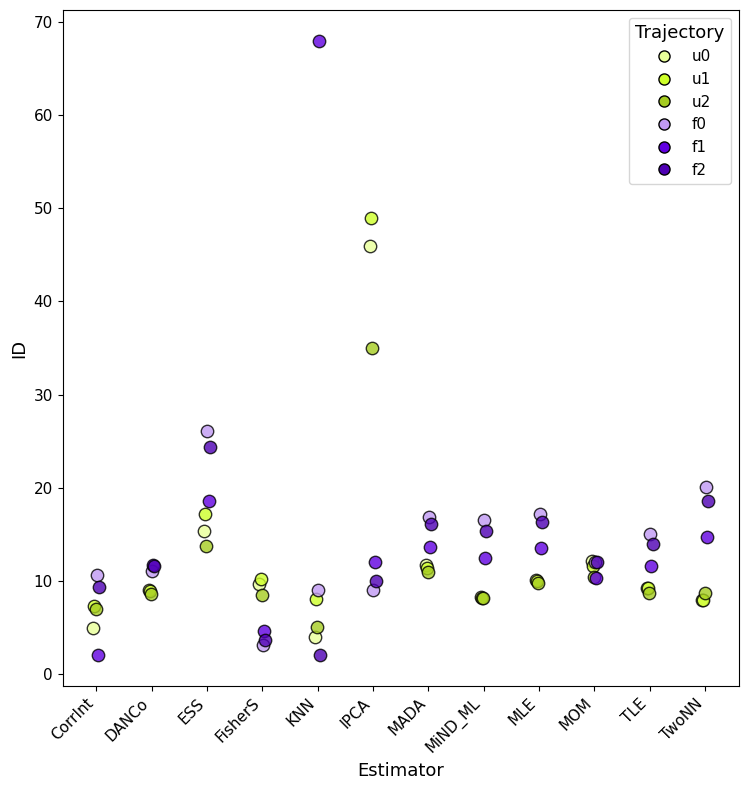

In [7]:
   
estimators = data2["estimator"].unique()
states = data2["trajectory"].unique()

fig, ax = plt.subplots(figsize=(8,8))

# assign colors from your custom cmap
color_map = {state: colors(i % colors.N) for i, state in enumerate(states)}

shift_amount = 0.05
n_traj = len(states)
shifts = np.linspace(-shift_amount, shift_amount, n_traj)
shift_map = dict(zip(states, shifts))

for _, row in data.iterrows():
    est_idx = np.where(estimators == row["estimator"])[0][0]

    # assign a slight offset depending on trajectory
    x = est_idx + shift_map[row["trajectory"]]

    mean_val = row["mean_all"]
    this_color = color_map[row["trajectory"]]

    ax.scatter(
        x, mean_val,
        color=this_color,
        edgecolor="black",
        alpha=0.8,
        s=80,
    )
ax.set_box_aspect(1)

# ticks & labels
ax.set_xticks(range(len(estimators)))
ax.set_xticklabels(estimators, rotation=45, ha="right")
ax.set_ylabel("ID")
ax.set_xlabel("Estimator")

# legend handles (consistent with scatter colors)
handles = [
    plt.Line2D([0],[0], marker='o', color='w',
               markerfacecolor=color_map[s], markeredgecolor='black',
               markersize=8, label=s)
    for s in states
]
ax.legend(handles=handles, title='Trajectory', loc='best')

plt.tight_layout()
#plt.savefig('../extra/ntl9_estimators_std.pdf', dpi=300)
plt.show()
